# MTMCT Method

Multi-target-multi-camera tracking (MTMCT) is for tracking people across different cameras or views.
![mtmc.png](imgs/mtmc.png)

## Key feature for tracking

For human-beings, we tend to assoicate a person to its name by looking at his/her appearance. How do computers mimic this association process like a human?
![obama.png](imgs/obama.png)

## Similarity between people

Computer represents appearance of a person by a vector. By computing the cross product between two vectors, we can someshow get an idea of how two vectors (appearances) are similar or not.

![cosine.png](imgs/cosine.png)

## How to get appearance vector

Therefore, it is important to train a model than can well discriminate two different people. This kind of model is called ReID model, which is used to transfrom a 2-dimensional image of person to a 1-dimensional vector.

![reid.png](imgs/reid.png)

## Single camera tracking

By now, we get an idea of how to measure the similarity between two people. Let's switch to single camera tracking.

In this scenario, a number of people are inside the shooting coverage of camera. Computer/Camera automatically gives IDs to each person in the camera view, and maintain the consistency of IDs over the time. You can apply DeepSORT algorithm to perform single camera tracking, which uses the appearance information to perform tracking.

![deepsort.png](imgs/deepsort.png)

## Multiple camera tracking

Suppose DeepSORT tracks objects pretty well. When some objects leave the view in origial camera and move into another camera, the tracking IDs assigned formerly are no longer consistent as they will get assigned new IDs by another camera.

To solve this problem, information between cameras must be supervised by an all-knowning role. It synchronize information between cameras, which means it remaps tracking IDs so that objects across cameras have same IDs.

![sync.png](imgs/sync.png)

# MTMCT clustering analysis

In [1]:
# Modify sys paths for importing development module
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath(".")))

# Import necessary modules
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

from colormap import rgb2hex
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from app.utils.visualize import draw_bbox, get_unique_color
from worker.mtmcworker.utils import crop_image
from worker.recognition import get_recognizer

## Read tracking profiles

In [2]:
def read_profile(fname):
    """Return the profile result of dict type
    
    Format:
        fid,tid,xmin,ymin,xmax,ymax,vx,vy
    """
    profile = {}
    
    with open(fname, "r") as f:
        content = f.read()
        lines = [ line for line in content.split("\n") if len(line) > 0]
        
        for line in lines:
            fields = [ float(field) for field in line.split(",") ]
            if int(fields[0]) not in profile:
                profile[int(fields[0])] = []
            profile[int(fields[0])].append(tuple(fields[2:2+4]))
    
    return profile

In [3]:
PROFILE_DIR = "result/MTMCApp/group/"

# Read tracking profile
pfiles = [ osp.join(PROFILE_DIR, f) for f in os.listdir(PROFILE_DIR) if f.endswith(".txt") ]
profiles = dict([ (pfile, { 'profile': read_profile(pfile) }) for pfile in pfiles ])

print("Number of profiles:", len(profiles))
for pfile in profiles.keys():
    print("-", pfile)

Number of profiles: 3
- result/MTMCApp/group/gHO_sGR_c01_d19_d20_d21_mHO4_ch10.mp4.txt
- result/MTMCApp/group/gHO_sGR_c02_d19_d20_d21_mHO4_ch10.mp4.txt
- result/MTMCApp/group/gHO_sGR_c08_d19_d20_d21_mHO4_ch10.mp4.txt


## Combine video reader with profile

In [4]:
# Combine video reader
for pfile in profiles.keys():
    vfile = osp.join(PROFILE_DIR, osp.basename(pfile).rstrip(".txt"))
    cap = cv2.VideoCapture(vfile)
    profiles[pfile]['capture'] = cap

## Select Target Frame with same number of people

In [5]:
# Hyperparameter
TARGET_FRAME = 500

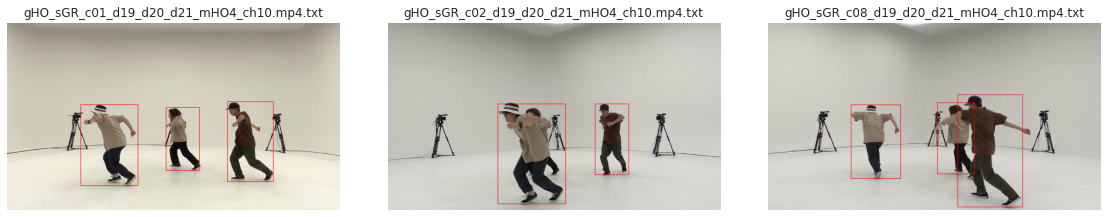

In [6]:
pfiles = list(profiles.keys())

# Visualization
fig, axes = plt.subplots(nrows=1, ncols=len(profiles), figsize=(16, 8))

# Show detected people
for idx, pfile in enumerate(pfiles):
    # Jump to target frame
    profiles[pfile]['capture'].set(cv2.CAP_PROP_POS_FRAMES, TARGET_FRAME)
    frame = profiles[pfile]['capture'].read()[1]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Draw bbox
    for bbox in profiles[pfile]['profile'][TARGET_FRAME]:
        box = np.array([ int(v) for v in bbox ])
        draw_bbox(frame, box, color=(255, 0, 0))

    # Show frame with bbox
    axes[idx].imshow(frame)
    axes[idx].set_title(osp.basename(pfile))
    axes[idx].set_axis_off()
    
plt.tight_layout()

## Show cropped images

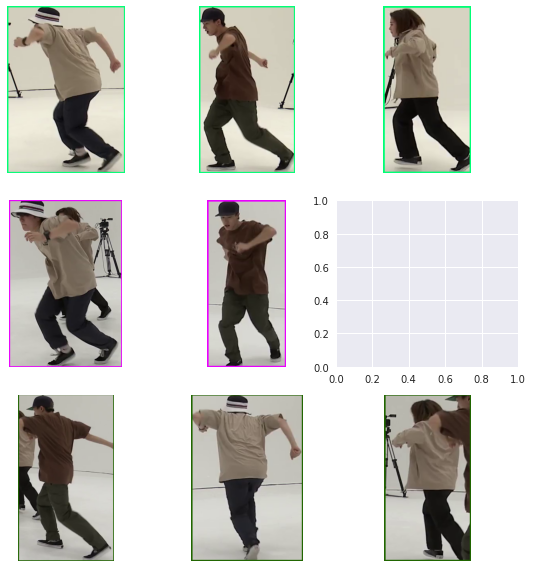

In [7]:
import re

pfiles = list(profiles.keys())
camera_regex = re.compile(r'.+_c(?P<cid>\d\d)_.+')

# Crop images
camera_people = {}
for idx, pfile in enumerate(pfiles):
    # Jump to target frame
    profiles[pfile]['capture'].set(cv2.CAP_PROP_POS_FRAMES, TARGET_FRAME)
    frame = profiles[pfile]['capture'].read()[1]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Extract Camera ID
    cid = int(camera_regex.match(osp.basename(pfile)).group('cid'))
    
    # Crop person images
    crop_imgs = []
    for bbox in profiles[pfile]['profile'][TARGET_FRAME]:
        crop_img = crop_image(frame, bbox)
        crop_imgs.append(crop_img)

    camera_people[cid] = crop_imgs
    
# Visualization
fig, axes = plt.subplots(nrows=len(camera_people),
                         ncols=max([ len(p) for p in camera_people.values() ]),
                         figsize=(8, 8))

for i, (cid, imgs) in enumerate(camera_people.items()):
    # Show cropped images
    color = get_unique_color(cid)
    for j, img in enumerate(imgs):
        draw_bbox(img, (0, 0, img.shape[1], img.shape[0]) ,color=color, thickness=5)
        axes[i][j].imshow(img)
        axes[i][j].set_axis_off()
    
plt.tight_layout()

## Map Person to embedding space

In [8]:
# Load recognizer model (ReID model)
recognizer = get_recognizer("Resnet18", { 'device': "cuda:3" })

In [9]:
pfiles = list(profiles.keys())
camera_regex = re.compile(r'.+_c(?P<cid>\d\d)_.+')

# Copmute embedding
all_crop_imgs = []
all_embeddings = []
camera_embeddings = {}
for idx, pfile in enumerate(pfiles):
    # Jump to target frame
    profiles[pfile]['capture'].set(cv2.CAP_PROP_POS_FRAMES, TARGET_FRAME)
    frame = profiles[pfile]['capture'].read()[1]
    
    # Extract Camera ID
    cid = int(camera_regex.match(osp.basename(pfile)).group('cid'))
    
    # Compute embedding of each person
    crop_imgs = []
    for bbox in profiles[pfile]['profile'][TARGET_FRAME]:
        crop_img = crop_image(frame, bbox)
        crop_imgs.append(crop_img)
        all_crop_imgs.append(crop_img)
    
    # Record embeddings
    embeddings_ = recognizer(crop_imgs)
    all_embeddings.append(embeddings_)
    camera_embeddings[cid] = embeddings_

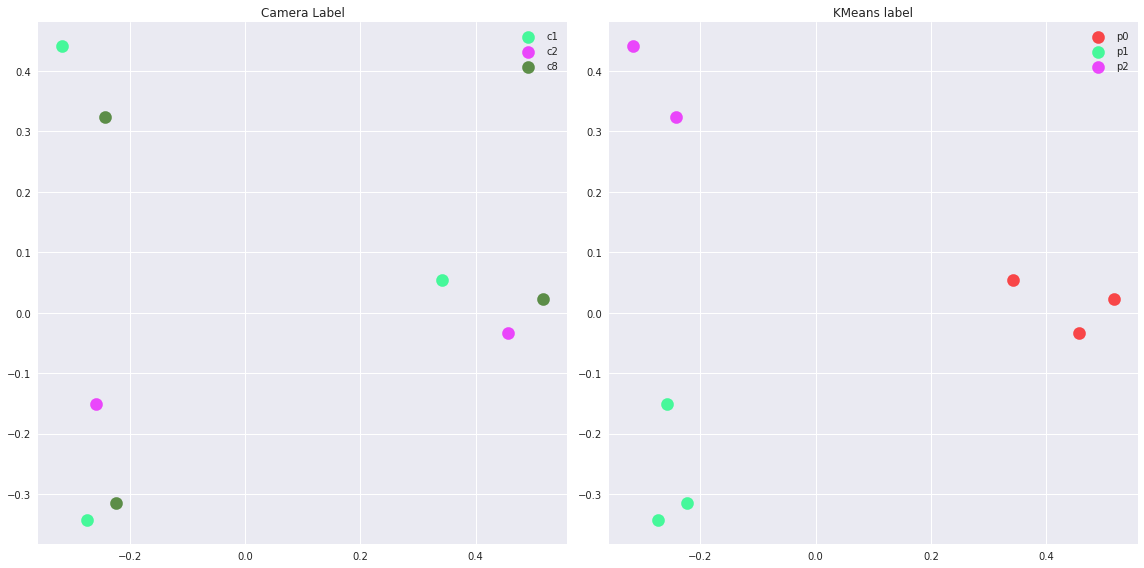

In [10]:
# Visualization Embedding
# ===============================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Dimension reduction to 2D space by PCA
embeddings = np.concatenate(all_embeddings)
pca = PCA(n_components=2)
pca = pca.fit(embeddings)

# Visualize 2D embedding space with camera id label
for i, (cid, embeddings_) in enumerate(camera_embeddings.items()):
    color = get_unique_color(cid)
    reduced = pca.transform(embeddings_)
    axes[0].scatter(x=reduced[:, 0], y=reduced[:, 1],
                s=150, c=rgb2hex(*color), alpha=0.7,
                label="c{}".format(cid))
    axes[0].legend()
    axes[0].set_title("Camera Label")

# Visualize 2D embedding space with person id labels (K-means label)
K = max([ len(embeddings_) for embeddings_ in camera_embeddings.values() ])
kmeans = KMeans(n_clusters=K)
kmeans = kmeans.fit(pca.transform(embeddings))

reduced = pca.transform(embeddings)
labels = kmeans.predict(reduced)

for label in set(labels):
    color = get_unique_color(label)
    indices = np.where(np.array(labels) == label)[0]
    target_embeddings = reduced[indices]
    axes[1].scatter(target_embeddings[:, 0], target_embeddings[:, 1],
                s=150, c=rgb2hex(*color), alpha=0.7,
                label="p{}".format(label))
    axes[1].legend()
    axes[1].set_title("KMeans label")

plt.tight_layout()

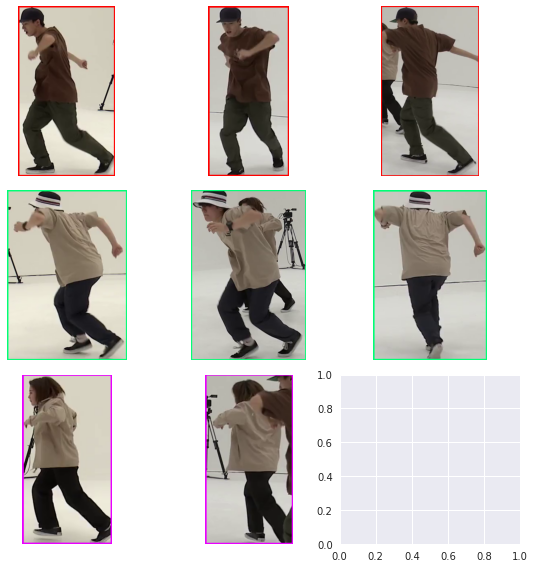

In [11]:
# Show original crop images with kmeans clustering
n_camera = len(profiles)
n_people = max([ len(embeddings_) for embeddings_ in camera_embeddings.values() ])

fig, axes = plt.subplots(nrows=n_people, ncols=n_camera, figsize=(8, 8))
for i, label in enumerate(set(labels)):
    color = get_unique_color(label)
    indices = np.where(np.array(labels) == label)[0]
    
    for j, pidx in enumerate(indices):
        crop_img = all_crop_imgs[pidx]
        crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
        draw_bbox(crop_img, (0, 0, crop_img.shape[1], crop_img.shape[0]), color=color, thickness=5)
        axes[i][j].imshow(crop_img)
        axes[i][j].set_axis_off()
        
plt.tight_layout()